In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv('./dataset/Tweets.csv')

In [3]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
data = data[['airline_sentiment', 'text']]

In [5]:
data.airline_sentiment.unique()

array(['neutral', 'positive', 'negative'], dtype=object)

In [6]:
data.airline_sentiment.value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [7]:
data_p = data[data.airline_sentiment == 'positive']

In [8]:
data_n = data[data.airline_sentiment == 'negative']

In [9]:
data_n = data_n.iloc[:len(data_p)]

In [10]:
len(data_n), len(data_p)

(2363, 2363)

In [11]:
data = pd.concat([data_n, data_p])

In [12]:
data = data.sample(len(data))

In [13]:
data['review'] = (data.airline_sentiment == 'positive').astype('int')

In [14]:
del data['airline_sentiment']

tf.keras.layers.Embedding  把文本向量化

In [15]:
import re

In [16]:
# 正则化式子
token = re.compile('[A-Za-z]+|[!?,.()]')

In [17]:
def reg_text(text):
    new_text = token.findall(text)
    new_text = [word.lower() for word in new_text]
    return new_text

In [18]:
data['text'] = data.text.apply(reg_text)

In [19]:
word_set = set()
for text in data.text:
    for word in text:
        word_set.add(word) 

In [20]:
# +1共有7101个单词
max_word = len(word_set) + 1
max_word

7101

In [21]:
word_list = list(word_set)

In [22]:
word_list.index('spending')

2349

In [23]:
word_index =  dict((word, word_list.index(word) + 1) for word in word_list)

In [24]:
word_index

{'terribleservice': 1,
 'so': 2,
 'dewithpew': 3,
 'hang': 4,
 'mia': 5,
 'strike': 6,
 'sba': 7,
 'yrs': 8,
 'limits': 9,
 'kindness': 10,
 'diego': 11,
 'nowhereland': 12,
 'pofsxojsy': 13,
 'happier': 14,
 'trading': 15,
 'nothing': 16,
 'mortified': 17,
 'dissatisfaction': 18,
 'zrh': 19,
 'jedediah': 20,
 'shaquille': 21,
 'lisa': 22,
 'smallest': 23,
 'southwestluv': 24,
 'keepitmovin': 25,
 'airborne': 26,
 'danger': 27,
 'vqtyza': 28,
 'hurricane': 29,
 'trvfncedl': 30,
 'together': 31,
 'year': 32,
 'xxy': 33,
 'toiletries': 34,
 'thier': 35,
 'experiencing': 36,
 'freddie': 37,
 'eliz': 38,
 'something': 39,
 'hour': 40,
 'reading': 41,
 'humor': 42,
 'improper': 43,
 'entertaining': 44,
 'somewhat': 45,
 'arrogant': 46,
 'keambleam': 47,
 'swaculture': 48,
 'aweful': 49,
 'unpredictable': 50,
 'continue': 51,
 'addressing': 52,
 'mjkpgvxmpc': 53,
 'cable': 54,
 'frequent': 55,
 'sincerely': 56,
 'forgot': 57,
 'dare': 58,
 'awfulness': 59,
 'ourguest': 60,
 'many': 61,
 'wth

In [25]:
# 没有单词返回为0 处理好的数据
data_ok = data.text.apply(lambda x: [word_index.get(word, 0) for word in x])

In [26]:
# 每一条信息的长度不一
len(data_ok.iloc[2])

16

In [27]:
# 获取最长长度
maxlen = max(len(x) for x in data_ok)

In [28]:
maxlen

40

In [29]:
# keras提供的方法，填充
data_ok = keras.preprocessing.sequence.pad_sequences(data_ok.values, maxlen=maxlen)

In [30]:
# 4726有一半是积极一半是消极
data_ok.shape

(4726, 40)

In [31]:
# 目标值
data.review.values

array([1, 0, 0, ..., 0, 0, 0])

In [32]:
# 初始化model
model = keras.Sequential()

Embeding : 把文本映射为一个密集向量

In [33]:
# Embeding : 把文本映射为一个密集向量 与 one hot 也是可以的
# word最大个数，密集向量的长度，每一个评论的长度
model.add(layers.Embedding(max_word, 50, input_length=maxlen))

In [34]:
# 隐藏单元，64 尽可能先打
model.add(layers.LSTM(64))

In [35]:
# dense做最后的判断
model.add(layers.Dense(1, activation='sigmoid'))

In [36]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 50)            355050    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                29440     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 384,555
Trainable params: 384,555
Non-trainable params: 0
_________________________________________________________________


In [37]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc']
)

In [38]:
# validation_split=0.2 就是说我们对数据进行切分 20% 作为测试数据
history = model.fit(data_ok, data.review.values, epochs=10, batch_size=128, validation_split=0.2)

c:\users\guanghua\anaconda3\envs\tensor\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3780 samples, validate on 946 samples
Epoch 1/10
3780/3780 [==============================] - 5s 1ms/step - loss: 0.6444 - acc: 0.6175 - val_loss: 0.5261 - val_acc: 0.7558
Epoch 2/10
3780/3780 [==============================] - 2s 634us/step - loss: 0.3917 - acc: 0.8280 - val_loss: 0.2234 - val_acc: 0.9154
Epoch 3/10
3780/3780 [==============================] - 2s 619us/step - loss: 0.1677 - acc: 0.9437 - val_loss: 0.2062 - val_acc: 0.9207
Epoch 4/10
3780/3780 [==============================] - 2s 618us/step - loss: 0.1070 - acc: 0.9661 - val_loss: 0.2118 - val_acc: 0.9292
Epoch 5/10
3780/3780 [==============================] - 2s 614us/step - loss: 0.0701 - acc: 0.9791 - val_loss: 0.2139 - val_acc: 0.9323
Epoch 6/10
3780/3780 [==============================] - 2s 614us/step - loss: 0.0416 - acc: 0.9899 - val_loss: 0.2848 - val_acc: 0.9249
Epoch 7/10
3780/3780 [==============================] - 2s 616us/step - loss: 0.0584 - acc: 0.9836 - val_loss: 0.3165 - val_acc: 0.9186
Epo

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

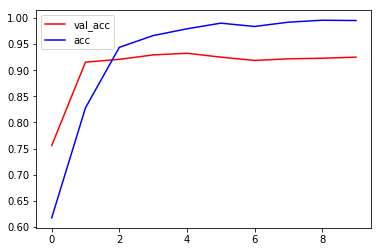

In [41]:
plt.plot(history.epoch, history.history.get('val_acc'), c='r', label='val_acc')
plt.plot(history.epoch, history.history.get('acc'), c='b', label='acc')
plt.legend()

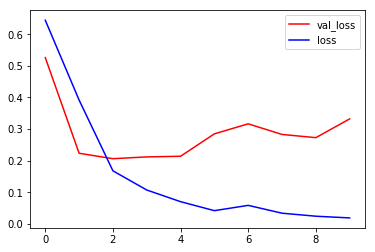

In [42]:
plt.plot(history.epoch, history.history.get('val_loss'), c='r', label='val_loss')
plt.plot(history.epoch, history.history.get('loss'), c='b', label='loss')
plt.legend()

使用循环 dropout 抑制过拟合

对每一个时间步使用相同的 dropout 掩码

In [63]:
def train_model():
    model = keras.Sequential()
    model.add(layers.Embedding(max_word, 16, input_length=maxlen))
    model.add(layers.LSTM(64,
                         dropout=0.2,
                         recurrent_dropout=0.5))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=keras.optimizers.RMSprop(),
              loss='binary_crossentropy',
              metrics=['acc'])
    return model

In [64]:
model2 = train_model()

In [65]:
history = model2.fit(data_ok, data.review.values, epochs=10, batch_size=128, validation_split=0.2)

c:\users\guanghua\anaconda3\envs\tensor\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3780 samples, validate on 946 samples
Epoch 1/10
3780/3780 [==============================] - 5s 1ms/step - loss: 0.6707 - acc: 0.6328 - val_loss: 0.6191 - val_acc: 0.7040
Epoch 2/10
3780/3780 [==============================] - 3s 745us/step - loss: 0.5590 - acc: 0.7270 - val_loss: 0.4686 - val_acc: 0.7770
Epoch 3/10
3780/3780 [==============================] - 3s 738us/step - loss: 0.4217 - acc: 0.8323 - val_loss: 0.3140 - val_acc: 0.8975
Epoch 4/10
3780/3780 [==============================] - 3s 735us/step - loss: 0.3101 - acc: 0.8931 - val_loss: 0.2416 - val_acc: 0.9154
Epoch 5/10
3780/3780 [==============================] - 3s 741us/step - loss: 0.2433 - acc: 0.9188 - val_loss: 0.2437 - val_acc: 0.8996
Epoch 6/10
3780/3780 [==============================] - 3s 749us/step - loss: 0.2028 - acc: 0.9354 - val_loss: 0.1999 - val_acc: 0.9165
Epoch 7/10
3780/3780 [==============================] - 3s 746us/step - loss: 0.1621 - acc: 0.9481 - val_loss: 0.1903 - val_acc: 0.9260
Epo

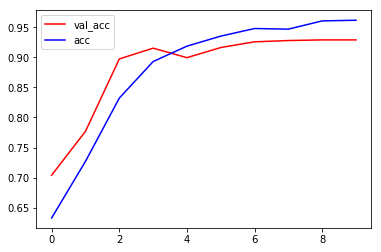

In [66]:
plt.plot(history.epoch, history.history.get('val_acc'), c='r', label='val_acc')
plt.plot(history.epoch, history.history.get('acc'), c='b', label='acc')
plt.legend()

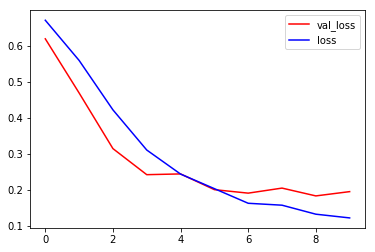

In [67]:
plt.plot(history.epoch, history.history.get('val_loss'), c='r', label='val_loss')
plt.plot(history.epoch, history.history.get('loss'), c='b', label='loss')
plt.legend()

# 使用双向 RNN

In [78]:
def train_model():
    model = keras.Sequential()
    model.add(layers.Embedding(max_word, 16, input_length=maxlen))
    model.add(layers.Bidirectional(layers.LSTM(64,
                         dropout=0.2,
                         recurrent_dropout=0.5)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=keras.optimizers.RMSprop(),
              loss='binary_crossentropy',
              metrics=['acc'])
    return model

In [79]:
model3 = train_model()

In [80]:
# 调节学习率，监控val_ loss,每3三个batch下降速率不变时候，
# 学习率下降0.3，最小学习速率为min Ir
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.3, min_lr=0.00001)

In [81]:
history = model3.fit(data_ok, 
                     data.review.values, 
                     epochs=30, 
                     batch_size=128, 
                     validation_split=0.2,
                     callbacks=[learning_rate_reduction])

Train on 3780 samples, validate on 946 samples
Epoch 1/30
3780/3780 [==============================] - 9s 2ms/step - loss: 0.6723 - acc: 0.6241 - val_loss: 0.6143 - val_acc: 0.6998
Epoch 2/30
3780/3780 [==============================] - 4s 1ms/step - loss: 0.4755 - acc: 0.7907 - val_loss: 0.3641 - val_acc: 0.8340
Epoch 3/30
3780/3780 [==============================] - 5s 1ms/step - loss: 0.3558 - acc: 0.8571 - val_loss: 0.2826 - val_acc: 0.8795
Epoch 4/30
3780/3780 [==============================] - 5s 1ms/step - loss: 0.2713 - acc: 0.9026 - val_loss: 0.3160 - val_acc: 0.8742
Epoch 5/30
3780/3780 [==============================] - 5s 1ms/step - loss: 0.2132 - acc: 0.9204 - val_loss: 0.2819 - val_acc: 0.8943
Epoch 6/30
3780/3780 [==============================] - 6s 2ms/step - loss: 0.1874 - acc: 0.9352 - val_loss: 0.2496 - val_acc: 0.9080
Epoch 7/30
3780/3780 [==============================] - 8s 2ms/step - loss: 0.1731 - acc: 0.9426 - val_loss: 0.2343 - val_acc: 0.9091
Epoch 8/30
3780

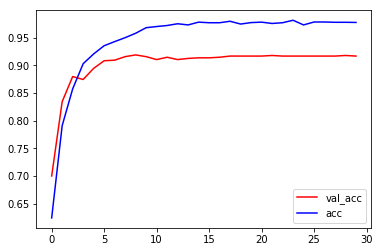

In [82]:
plt.plot(history.epoch, history.history.get('val_acc'), c='r', label='val_acc')
plt.plot(history.epoch, history.history.get('acc'), c='b', label='acc')
plt.legend()

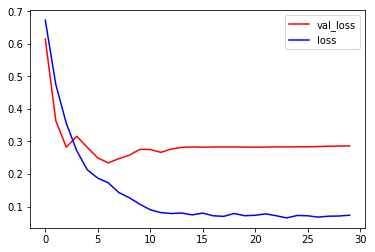

In [83]:
plt.plot(history.epoch, history.history.get('val_loss'), c='r', label='val_loss')
plt.plot(history.epoch, history.history.get('loss'), c='b', label='loss')
plt.legend()